# There is no plan bee without them 🐝

## Abstract
Pollinators around the world play a central role in our agriculture with an estimated economic benefit of €235bn per year. Up to 75% of our crops are dependent on pollination and honeybees account for most of it. Yet, in Europe and the USA the bee population has been declining at an alarming rate during the last decades. As by-hand pollination is not an alternative, it is impossible to imagine a world without them. [1]

With this project, we first aim at giving insights about the state of bee health and honey produced and traded using the [FAO datasets](http://www.fao.org/faostat/en/#data). Secondly, we focus on the USA using results from [US Departement of Agriculture](https://quickstats.nass.usda.gov/) in order to identify and present the main factors of bee decline. Finally, we propose a case study about almonds in California to show the consequences of a lack of bees.

[[1](http://sos-bees.org/wp-content/uploads/2014/04/BeesInDecline.pdf)] *Bees in Decline*, Greenpeace, 2013



In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## 1. How do the continents compare in terms of bee decline from 1961 to these days?

Robin

## 2. How do changes in honey production relate to number of beehives in Europe and the USA?

Robin

## 3. What are the consequences of bee decline on the patterns of honey import/export around the world?

Eric

# 4. What is the relation between US cases of Colony Collapse Disorder and its main factors ?

The cause (or causes) of **Colony Collapse Disorder (CCD)** is not quite clear. It is thought to have several plausible causes, including:

- Pesticide use
- Bee pests (most specifically the Varroa)
- Environmental stresses

In this section, we study the influence of some of those factors

In [178]:
# Add code
states = {'alaska': 'AK',
 'alabama': 'AL',
 'arkansas': 'AR',
 'american samoa': 'AS',
 'arizona': 'AZ',
 'california': 'CA',
 'colorado': 'CO',
 'connecticut': 'CT',
 'district of columbia': 'DC',
 'delaware': 'DE',
 'florida': 'FL',
 'georgia': 'GA',
 'guam': 'GU',
 'hawaii': 'HI',
 'iowa': 'IA',
 'idaho': 'ID',
 'illinois': 'IL',
 'indiana': 'IN',
 'kansas': 'KS',
 'kentucky': 'KY',
 'louisiana': 'LA',
 'massachusetts': 'MA',
 'maryland': 'MD',
 'maine': 'ME',
 'michigan': 'MI',
 'minnesota': 'MN',
 'missouri': 'MO',
 'northern mariana islands': 'MP',
 'mississippi': 'MS',
 'montana': 'MT',
 'national': 'NA',
 'north carolina': 'NC',
 'north dakota': 'ND',
 'nebraska': 'NE',
 'new hampshire': 'NH',
 'new jersey': 'NJ',
 'new mexico': 'NM',
 'nevada': 'NV',
 'new york': 'NY',
 'ohio': 'OH',
 'oklahoma': 'OK',
 'oregon': 'OR',
 'pennsylvania': 'PA',
 'puerto rico': 'PR',
 'rhode island': 'RI',
 'south carolina': 'SC',
 'south dakota': 'SD',
 'tennessee': 'TN',
 'texas': 'TX',
 'utah': 'UT',
 'virginia': 'VA',
 'virgin islands': 'VI',
 'vermont': 'VT',
 'washington': 'WA',
 'wisconsin': 'WI',
 'west virginia': 'WV',
 'wyoming': 'WY'}

In [257]:
loss = pd.read_excel("data/Bee Colony Loss.xlsx")
pesti = pd.read_csv("data/FAOSTAT_pesticide.csv")
varroa_all = pd.read_csv("data/USDA_varroa.csv")

### Varroa preprocessing

In [258]:
varroa_all.sample(3)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
1411,SURVEY,2015,APR THRU JUN,NaN,STATE,VERMONT,50.0,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL ...",TOTAL,NOT SPECIFIED,1.9,NaN
555,SURVEY,2017,JAN THRU MAR,NaN,STATE,UTAH,49.0,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL ...",TOTAL,NOT SPECIFIED,0,NaN
77,SURVEY,2019,JAN THRU MAR,NaN,STATE,TENNESSEE,47.0,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES, AFFECTED BY VARROA MITES ...",TOTAL,NOT SPECIFIED,62.8,NaN


In [259]:
VARROA_TO_KEEP = ['Year', 'State', 'Data Item', 'Value']
varroa_all = varroa_all[VARROA_TO_KEEP]

varroa_all.columns = [column.strip().lower() for column in varroa_all.columns]

In [260]:
varroa_all['data item'].value_counts()

HONEY, BEE COLONIES, AFFECTED BY VARROA MITES - INVENTORY, MEASURED IN PCT OF COLONIES                   802
HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL VARROA MITES)) - INVENTORY, MEASURED IN PCT OF COLONIES    799
SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $                            7
HONEY, BEE COLONIES, AFFECTED BY PESTS (EXCL VARROA MITES) - INVENTORY, MEASURED IN PCT OF COLONIES        3
Name: data item, dtype: int64

In [261]:
# We get rid of 'SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $'
varroa_all = varroa_all[varroa_all['data item'] != 'SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $']

# We get rid of US totals (which gets rid of the above HONEY, BEE COLONIES, AFFECTED BY PESTS (EXCL VARROA MITES) - INVENTORY, MEASURED IN PCT OF COLONIES)
varroa_all = varroa_all[varroa_all.state != 'US TOTAL']

varroa_all.state = varroa_all.state.apply(str.lower)

In [262]:
for value in varroa_all.value:
    try:
        float(value)
    except:
        print(value)

 (Z)
 (Z)
 (Z)
 (Z)
 (Z)


In [263]:
varroa_all = varroa_all[varroa_all.value != ' (Z)']
varroa_all.value = varroa_all.value.apply(float)

In [264]:
# We separate Varroa from Non-varroa
varroa = varroa_all[varroa_all['data item'] == 'HONEY, BEE COLONIES, AFFECTED BY VARROA MITES - INVENTORY, MEASURED IN PCT OF COLONIES']
varroa = varroa[['year', 'state', 'value']]

non_varroa = varroa_all[varroa_all['data item'] == 'HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL VARROA MITES)) - INVENTORY, MEASURED IN PCT OF COLONIES']
non_varroa = non_varroa[['year', 'state', 'value']]


In [265]:
varroa.head()

,year,state,value
3,2019,alabama,27.2
5,2019,arizona,25.8
7,2019,arkansas,19.5
9,2019,california,43.5
11,2019,colorado,11.2


### Pesticide preprocessing

In [266]:
pesti.head(3)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,RP,Pesticides Use,3,Albania,5157,Agricultural Use,1357,Pesticides (total),1990,1990,tonnes,121.0,A,"Aggregate, may include official, semi-official..."
1,RP,Pesticides Use,3,Albania,5157,Agricultural Use,1357,Pesticides (total),1991,1991,tonnes,121.0,A,"Aggregate, may include official, semi-official..."
2,RP,Pesticides Use,3,Albania,5157,Agricultural Use,1357,Pesticides (total),1992,1992,tonnes,121.0,A,"Aggregate, may include official, semi-official..."


In [267]:
# Cleaning

# Domain is always "Pesticides Use"
# Unit is always "tonnes"
# Element is always "Agricultural Use"
PESTI_TO_KEEP = ['Area', 'Item', 'Year', 'Value', 'Flag']
pesti = pesti[PESTI_TO_KEEP]

pesti.columns = [column.strip().lower() for column in pesti.columns]

In [268]:
pesti.head(3)

,area,item,year,value,flag
0,Albania,Pesticides (total),1990,121.0,A
1,Albania,Pesticides (total),1991,121.0,A
2,Albania,Pesticides (total),1992,121.0,A


### Loss preprocessing


In [269]:
loss.head(3)

,Year,Season,State,Total Annual Loss,Beekeepers,Beekeepers Exclusive to State,Colonies,Colonies Exclusive to State
0,2016/17,Annual,Massachusetts,0.159,87,0.943,27186,0.023
1,2016/17,Annual,Montana,0.171,21,0.524,35905,0.003
2,2016/17,Annual,Nevada,0.230,13,0.923,2512,0.052


As per the [source](https://data.world/finley/bee-colony-statistical-data-from-1987-2017), **Total annual loss** is the percentage of colony lost during that year

In [270]:
# Cleaning 

# Clean header
loss.columns = [column.strip().lower() for column in loss.columns]

# Season is always Annual 
loss.drop('season', axis=1, inplace=True)

# 2016/17 => 2016
loss.year = loss.year.apply(lambda x: int(x[:-3]))

# lowercase the state
loss.state = loss.state.apply(str.lower)

In [271]:
loss.head(3)

,year,state,total annual loss,beekeepers,beekeepers exclusive to state,colonies,colonies exclusive to state
0,2016,massachusetts,0.159,87,0.943,27186,0.023
1,2016,montana,0.171,21,0.524,35905,0.003
2,2016,nevada,0.230,13,0.923,2512,0.052


Text(0, 0.5, 'Annual loss [%]')

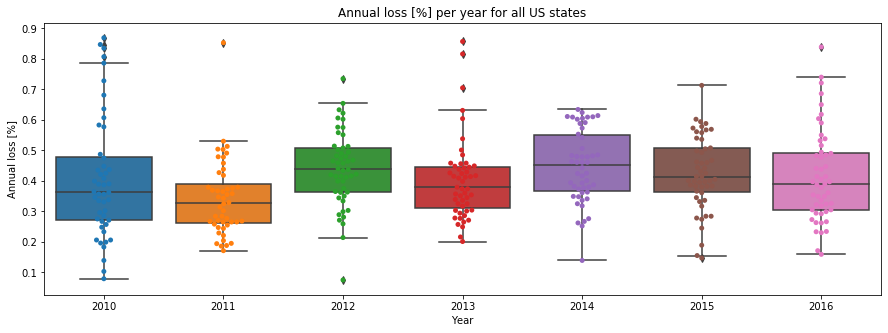

In [272]:
plt.figure(figsize=(15,5))
sns.boxplot(y='total annual loss', x='year', data=loss)
sns.swarmplot(y='total annual loss', x='year', data=loss)
plt.title('Annual loss [%] per year for all US states')
plt.xlabel('Year')
plt.ylabel('Annual loss [%]')

## Average loss of beehives [%] per State

In [273]:
# Plot US states heatmap 
loss_per_state = loss.groupby('state').mean()['total annual loss'].reset_index()
loss_per_state.columns = ['state', 'average annual loss']

In [274]:
loss_per_state.replace(to_replace=states, inplace=True) 
loss_per_state.dropna(inplace=True)
loss_per_state['average annual loss'] *= 100

In [275]:
loss_per_state.head()

,state,average annual loss
0,AL,35.942857
2,AZ,40.614286
3,AR,37.642857
4,CA,35.714286
5,CO,38.442857


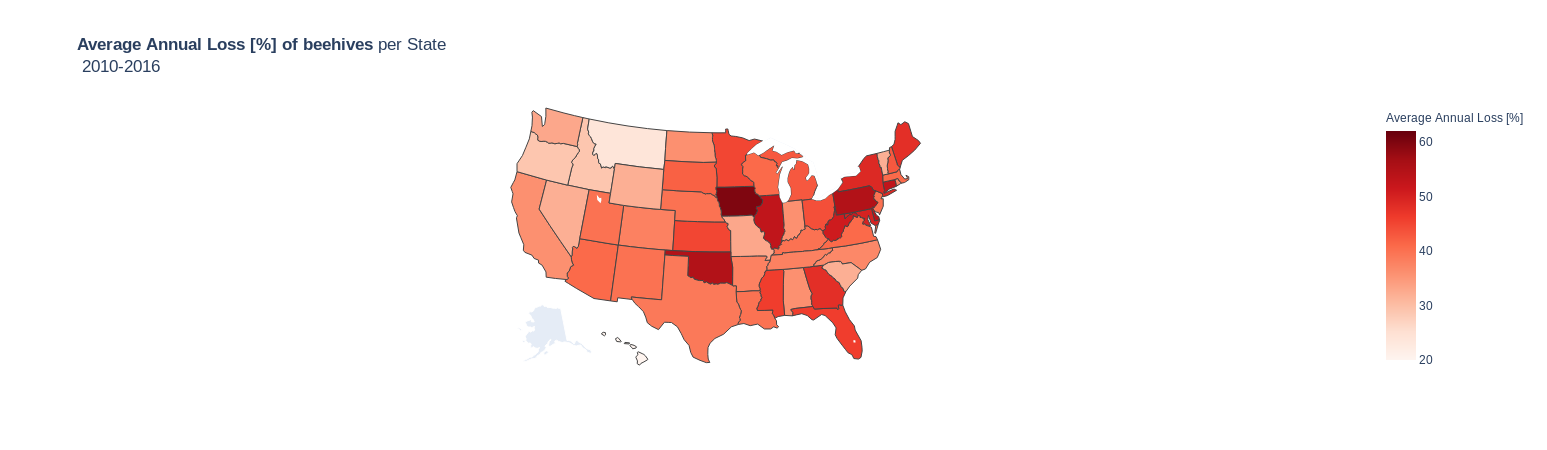

In [276]:
fig = go.Figure(data=go.Choropleth(
    locations=loss_per_state['state'],
    z=loss_per_state['average annual loss'].astype(float).apply(round),
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title='Average Annual Loss [%]',
))

fig.update_layout(
    title_text = '<b>Average Annual Loss [%] of beehives</b> per State <br> 2010-2016 ',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.show()

## Bee pests 


In [282]:
varroa.head(3)

,year,state,value
3,2019,AL,27.2
5,2019,AZ,25.8
7,2019,AR,19.5


In [284]:
non_varroa.head(3)

,year,state,value
2,2019,alabama,22.7
4,2019,arizona,7.9
6,2019,arkansas,1.5


In [285]:
varroa.replace(to_replace=states, inplace=True) 
non_varroa.replace(to_replace=states, inplace=True) 


In [279]:
varroa_per_state = varroa.groupby('state').mean()['value'].reset_index()
varroa_per_state.head(3)

,state,value
0,AL,27.058824
1,AR,45.229412
2,AZ,42.611765


In [286]:
non_varroa_per_state = non_varroa.groupby('state').mean()['value'].reset_index()
non_varroa_per_state.head(3)

,state,value
0,AL,25.452941
1,AR,14.552941
2,AZ,11.670588


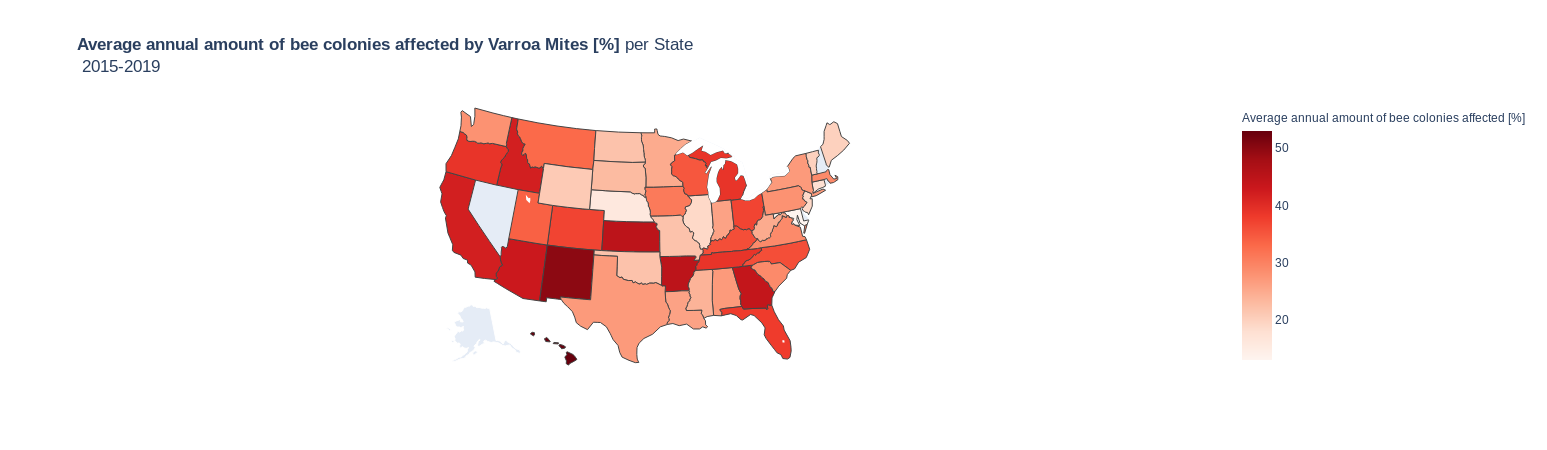

In [289]:
fig = go.Figure(data=go.Choropleth(
    locations=varroa_per_state['state'],
    z=varroa_per_state['value'].astype(float).apply(round),
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title='Average annual amount of bee colonies affected [%]',
))

fig.update_layout(
    title_text = '<b>Average annual amount of bee colonies affected by Varroa Mites [%]</b> per State <br> 2015-2019',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.show()

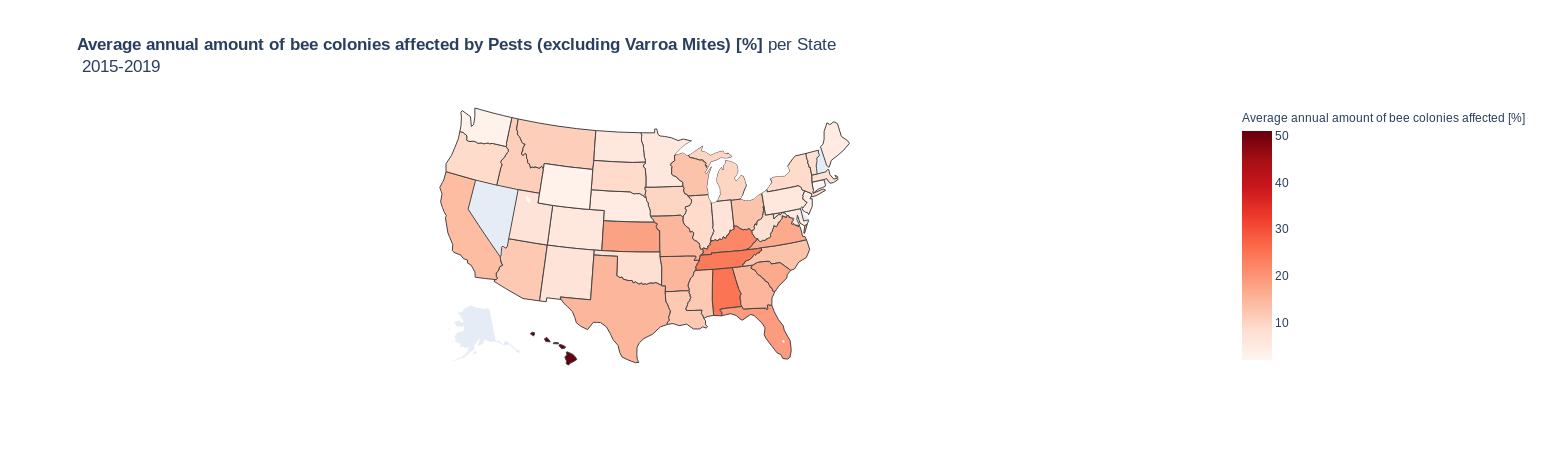

In [290]:
fig = go.Figure(data=go.Choropleth(
    locations=non_varroa_per_state['state'],
    z=non_varroa_per_state['value'].astype(float).apply(round),
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title='Average annual amount of bee colonies affected [%]',
))

fig.update_layout(
    title_text = '<b>Average annual amount of bee colonies affected by Pests (excluding Varroa Mites) [%]</b> per State <br> 2015-2019',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.show()

## Pesticide use [tonnes] per State

In [281]:
pesti.head()

,area,item,year,value,flag
0,Albania,Pesticides (total),1990,121.0,A
1,Albania,Pesticides (total),1991,121.0,A
2,Albania,Pesticides (total),1992,121.0,A
3,Albania,Pesticides (total),1993,121.0,A
4,Albania,Pesticides (total),1994,201.0,A


In [97]:
# Let's only care about total pesticide for now
total_pesti_per_state= pesti[pesti.item == 'Pesticides (total)']

In [104]:
total_pesti_per_state.area.unique()

array(['Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belgium-Luxembourg', 'Belize', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cameroon', 'Canada', 'Central African Republic',
       'Chad', 'Chile', 'China', 'China, Hong Kong SAR',
       'China, Macao SAR', 'China, mainland', 'China, Taiwan Province of',
       'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica',
       "Côte d'Ivoire", 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Eritrea',
       'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'French Polynesia', 'Gambia', 'Germany', 'Ghana', 'Greece',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti',
     

In [94]:
# Only keep US states 
total_pesti_per_state = total_pesti_per_state[total_pesti_per_state.area.isin(list(states.keys()))]

In [95]:
total_pesti_per_state

,area,item,year,value,flag


## 5. California accounts for 80% of the world almond production, what is the impact of bees on this industry in the 21st century?

Tim & Arthur